# Empty crosswords 2

Attempt 2 at making an empty crossword generator. This version defines a number of constraints that need to be satisfied, and performs simulated annealing to find a good crossword in a random walk through all boolean grids.

## Import

In [1]:
import numpy as np
import random
import math

#for viewing
import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

## Initiate crossword

In [34]:
size = 13

def makeGrid(size):
    grid = np.rint(np.random.rand(size, size)).astype(bool)
    for x in range(size):
        for y in range(size):
            grid[y,x] = grid[-(y + 1),-(x + 1)]
    
    return grid

grid = makeGrid(13)

## Grid reading functions

Various functions that help in in processing a crossword grid

In [3]:
def isStart(x, y, grid, direction):
    'indicates whether the given coordinates mark the start of a sequence'
    if grid[y,x]:
        size = grid.shape[0]
        if direction == 'hor':
            if x < size - 1:
                if x == 0 or not grid[y,x-1]:  #if there is no white square to the left...
                    if grid[y,x+1]:            #... and there is a white square to the right
                        return True
        if direction == 'ver':
            if y < size - 1:
                if y == 0 or not grid[y-1,x]: #if there is no white square above...
                    if grid[y+1,x]:           #... and there is a white square below
                        return True
    return False

def startingCors(grid, direction):
    size = grid.shape[0]
    return [(y,x) for x in range(size) for y in range(size) if isStart(x,y,grid,direction)]

In [4]:
def seqLength(x,y,grid,direction):
    'gives the length of the sequence starting from the given coordinates'
    
    #get the rest of the row/column
    if direction == 'hor':
        rest = grid[y,x:]
    else:
        rest = grid[y:,x]
        
    for i, value in enumerate(rest):
        if not value:
            return i
    
    return(len(rest))
    

## Constraints

A number of functions that define constraints on empty crossword. Each function takes an empty crossword as input, and outputs the number of violations of the constraint.

In [5]:
def minLength(grid, min_length=3):
    'returns number of sequences that are shorter than the minimum length'
    lengths = [seqLength(x,y,grid, direction) for direction in ('hor', 'ver') for y,x in startingCors(grid, direction)]
    
    violations = len([l for l in lengths if l < min_length])
    
    return violations

In [6]:
def neighbours(x,y,grid):
    'give coordinates of neighbours in von neumann neighbouhood for which the square is True in the grid'
    size = grid.shape[0]
    neighbourhood = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]
    neighbourhood = [(x_1, y_1) for x_1, y_1 in neighbourhood if x_1 >= 0 and x_1 < size and y_1 >= 0 and y_1 < size]
    return [(x_1,y_1) for x_1, y_1 in neighbourhood if grid[y_1,x_1]]
                

def islands(grid):
    'return the number of islands - 1. (There should be only 1.)'
    size = grid.shape[0]
    islands = 0
    new_grid = np.copy(grid)
    for x in range(size):
        for y in range(size):
            if new_grid[y,x]:
                #add one to count
                islands += 1
                
                #set rest of island to False
                connected = neighbours(x,y,new_grid)
                while len(connected) > 0:
                    x_1, y_1 = connected[0]
                    if new_grid[y_1, x_1]:
                        #set to false and append its neighbours
                        new_grid[y_1,x_1] = False                      
                        connected = connected[1:] + neighbours(x_1, y_1, new_grid) 
                    else:
                        #or just delete it
                        connected = connected[1:]
    
    return islands - 1

In [27]:
def blackWhiteBalance(grid):
    'checks that at most 80% of squares are white and at most 30% are black. returns the overflow in either direction.'
    size = grid.shape[0]
    total_count = size ** 2
    
    max_white = int(0.8 * total_count)
    white_count = np.sum(grid)
    overflow = max(white_count - max_white, 0)
    
    if not overflow:
        max_black = int(0.3 * total_count)
        black_count = total_count - white_count
        overflow = max(black_count - max_black, 0)
    
    return overflow

In [39]:
def lengthBalance(grid):
    'checks that there are not too many sequences of length three.'
    lengths = [seqLength(x,y,grid, direction) for direction in ('hor', 'ver') for y,x in startingCors(grid, direction)]
    threes = filter(lambda x: x == 3, lengths)
    
    max_threes = int(0.3 * len(lengths))
    overflow = max(0, sum(threes)/3 - max_threes)
    
    return overflow

In [40]:
def maxLength(grid):
    "a random walk favours short word lengths. this constraints checks that there are at least a few longer ones"
    min_length = 9
    min_count = 3
    
    lengths = [seqLength(x,y,grid, direction) for direction in ('hor', 'ver') for y,x in startingCors(grid, direction)]
    long_count = sum(1 for l in lengths if l >= min_length)
    defecit = max(0, min_count - long_count)
    
    return defecit

In [58]:
def whiteBlocks(grid):
    'limits the number of 3x3 blocks that are only white squares. maximum is 2.'
    size = grid.shape[0]
    
    is_block = lambda x, y: np.all(grid[y : y+3, x : x+3])
    
    blocks = sum(int(is_block(x,y)) for x in range(size - 3) for y in range(size - 3))
    
    return blocks - 2

In [59]:
def loss(grid):
    #note: it may be interesting to add a weight to different constraints
    constraints =  [minLength, islands, blackWhiteBalance, lengthBalance, maxLength, whiteBlocks]
    return sum(f(grid) for f in constraints)

## Perform search with simulated annealing

In [9]:
def step(grid):
    new_grid = np.copy(grid)
    size = grid.shape[0]
    x = random.choice(range(size))
    y = random.choice(range(size))
    new_grid[y,x] = not new_grid[y,x]
    new_grid[-(y+1), -(x+1)] = new_grid[y,x]
    return new_grid

def P(old_loss, new_loss, T):
    if new_loss < old_loss:
        return 1
    else:
        return math.exp(-1 * (new_loss - old_loss)/T)

In [64]:
grid = makeGrid(13)

loss_log = []
l = loss(grid)
max_iterations = 2000

for i in range(max_iterations):
    loss_log.append(l)
    T = max_iterations/(i + 1)
    neighbour = step(grid)
    l_neighbour = loss(neighbour)
    
    if P(l, l_neighbour, T) >= random.random():
        grid = neighbour
        l = l_neighbour
    
    if l == 0:
        break

print(l)

0


Text(0, 0.5, 'loss')

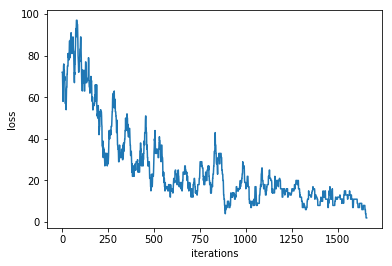

In [65]:
plt.plot(loss_log)
plt.xlabel('iterations')
plt.ylabel('loss')

## Show grid

Image display of crossword. Adapted from [printi-my-crosswords](github.com/lukavdplas/printi-my-crosswords).

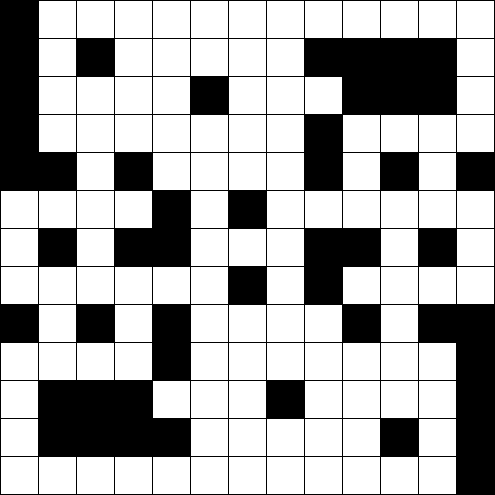

In [66]:
max_width = 500
square_size = int((max_width - 1) / size)
img_size = square_size * size + 1

#create blank image
img = PIL.Image.new('1', (img_size, img_size), color=1)

#draw vertical grid lines
for i in range(size):
    x = i * square_size
    for y in range(img_size):
        img.putpixel((x,y), 0)

#draw horizontal grid lines
for i in range(size):
    y = i * square_size
    for x in range(img_size):
        img.putpixel((x,y), 0)

#final vertical and horizontal lines
for y in range(img_size):
    img.putpixel((-1,y), 0)
for x in range(img_size):
    img.putpixel((x,-1), 0)

#fill in black squares
for i in range(size):
    for j in range(size):
        value = int(grid[j][i])   #1 for white squares, 0 for black squares
        if value == 0:
            x_min, x_max = i * square_size, (i+1) * square_size
            y_min, y_max = j * square_size, (j+1) * square_size

            for x in range(x_min, x_max):
                for y in range(y_min, y_max):
                    img.putpixel((x,y), 0)

img

[3, 4, 5, 4, 5, 9, 11, 7, 6, 6, 9, 7, 6, 6, 5, 5, 4, 4, 3, 4, 3, 4, 8, 10, 4, 3, 5, 6, 4, 4, 6, 5, 3, 4, 10, 8, 4, 3, 4]


Text(0, 0.5, 'count')

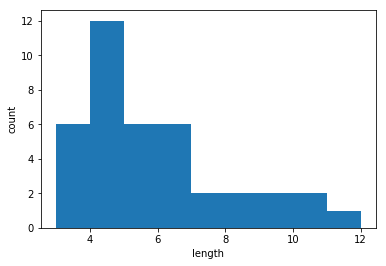

In [51]:
#division of sequence lengths:
 
lengths = [seqLength(x,y,grid, direction) for direction in ('hor', 'ver') for y,x in startingCors(grid, direction)]

plt.hist(lengths, bins=range(min(lengths), max(lengths) + 2))
plt.xlabel('length')
plt.ylabel('count')